Each models is required to generate a stack ranking of all properties listed for sale in the database.

This script runs daily, reads in CSV files with a sorted order of homes (most attractive at the top to least attractive at the bottom), and a 'ypred' variable that reflects the scripts absolute metric (like P&L or probability of sale).

The script compares each list with homes that were sold, and identifies closed transactions ('positives') as well as the top 10 properties that each model identified that didn't sell ('negatives'). The remainder is considered 'control set'. 

For the overall data set, and specifically for each of those 3 groups, we output the average 'ypred' value, what number and percentage of homes sold from each.

In [14]:
import pandas as pd
import numpy as np
import datetime as dt
import os
from slacker import Slacker
import json
import requests
from cloudinary.uploader import upload
from cloudinary.utils import cloudinary_url
from cloudinary.api import delete_resources_by_tag, resources_by_tag

csv_path = '/home/ilya/Code/rentalnerd/scraper/'
today = dt.date.today()


%matplotlib inline
        
# slack secrets (in your ~/.bashrc)
webhook_url = os.environ.get('SLACK_URL')
slacker = Slacker(os.environ.get('SLACK_TOKEN'))

# how old a target list to compare to the current target list
lag_days = 40

pd.set_option('display.max_colwidth', -1)
discount = 0.050

# to remove all the random far away areas - PHX only
zipcode_list = ['85006', '85007', '85008', '85009', '85013', '85015', '85016', '85017',
       '85018', '85019', '85020', '85021', '85022', '85023', '85024',
       '85027', '85028', '85029', '85031', '85033', '85035', '85037',
       '85040', '85041', '85043', '85044', '85048', '85050', '85051',
       '85053', '85085', '85086', '85087', '85118', '85138', '85139',
       '85142', '85143', '85202', '85203', '85204', '85205', '85206',
       '85207', '85209', '85210', '85212', '85213', '85215', '85224',
       '85225', '85226', '85233', '85234', '85248', '85249', '85250',
       '85251', '85253', '85254', '85255', '85257', '85258', '85262',
       '85266', '85286', '85295', '85296', '85297', '85298', '85301',
       '85302', '85303', '85304', '85305', '85306', '85308', '85310',
       '85323', '85326', '85331', '85335', '85339', '85340', '85351',
       '85353', '85355', '85373', '85374', '85375', '85382', '85383',
       '85388', '85390', '85392', '85396', '85704', '85705', '85706',
       '85711', '85712']

In [15]:
def plot_rounds(plot):
    # uploads the graph to the web and returns the URL
    
    fig = plot.get_figure()
    fig.tight_layout()
    fig.savefig('temp_plot.png')
    
    response = upload("temp_plot.png")
    url, options = cloudinary_url(response['public_id'],
        format = response['format'],
        crop = "fill")
    return url

In [16]:
def slack(text, url = None, title = None):
    print("Slacking: " + text)
    
    if url == None:
        data=json.dumps({"text": text})
    else:
        data = json.dumps( { "text": text, "attachments": [ { "fallback": "Model MAE"
                                           , "title": title
                                           , "image_url": url } ] } )
    
    response = requests.post(webhook_url, data , headers={'Content-Type': 'application/json'})
    if response.status_code != 200:
        raise ValueError('Request to slack returned an error %s, the response is:\n%s' % (response.status_code, response.text))


In [17]:
closed = pd.read_csv('CSV_backups/ALL-sales.csv',nrows=10000000, index_col=['property_id','transaction_id'])

/home/ilya/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (12,14,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [18]:
closed.head()

,,price,transaction_status,date_listed,date_closed,days_on_market,transaction_type,price_listed,price_closed,date_transacted_latest,fsbo,...,school_district_id_68.0,school_district_id_75.0,school_district_id_76.0,school_district_id_8.0,school_district_id_87.0,school_district_id_90.0,school_district_id_93.0,school_district_id_95.0,school_district_id_96.0,school_district_id_nan
property_id,transaction_id,,,,,,,,,,,,,,,,,,,,,
9018747,22729882,106100,closed,NaN,4526,NaN,sales,NaN,106100.0,2012-05-23,0.0,...,0,0,0,0,0,0,0,0,0,0
9018745,22729880,140000,closed,NaN,3453,NaN,sales,NaN,140000.0,2009-06-15,0.0,...,0,0,0,0,0,0,0,0,0,0
9018809,22729795,104900,closed,2009-10-11,3628,57.0,sales,104900.0,104900.0,2009-12-07,0.0,...,0,0,0,0,0,0,0,0,0,0
9018808,22729790,141296,closed,NaN,1329,NaN,sales,NaN,141296.0,2003-08-22,0.0,...,0,0,0,0,0,0,0,0,0,0
9018966,22729652,225000,closed,NaN,1945,NaN,sales,NaN,225000.0,2005-04-29,0.0,...,0,0,0,0,1,0,0,0,0,0


In [19]:
# read in prior target list for backtesting purposes
model_results = np.empty([0,7])
for lag_days in range(1,2):
    print("Lag days %i\n\n" % lag_days)
    try:
        prior_target_list = pd.read_csv(csv_path + 'good_sell/gs_target_list_' + (today-dt.timedelta(days=lag_days)) \
                                    .strftime('%Y%m%d') + '.csv', index_col = [0,1]) \
                                    .rename(columns = { 'ypred' : 'good_sell_prob'})

        backtest = prior_target_list.join(closed[['price']], how="inner").sort_values(by='good_sell_prob',ascending=False)
        backtest['good_sell'] = (backtest.price >= (backtest.list * (1-discount)))
        y_all = prior_target_list.good_sell_prob.mean()
        y_sold = backtest.good_sell_prob.mean()

        pos_trigger = prior_target_list.good_sell_prob.quantile(0.75)
        slack("Prior target list length: %i\tNum sold: %i\tAvg good sell prob: %f\tAvg good sell prob of sold: %f" 
              % (len(prior_target_list.index), len(backtest.index),y_all, y_sold))

        num_pos = len(prior_target_list[prior_target_list.good_sell_prob > pos_trigger].index)
        positives = backtest[backtest.good_sell_prob > pos_trigger]
        y_pos = (-(positives.price - positives.list) / positives.list).median()
        num_sold = len(positives.index)
        if num_sold == 0:
            slack("Num of homes with good_sell_prob > %f: %i\tPerc of those sold: NONE\tMed disc to list: NA" % (pos_trigger, num_pos) )    
        else:
            slack("Num of homes with good_sell_prob > %f: %i\tPerc of those sold: %f\tMed disc to list: %f" 
                  % (pos_trigger, num_pos, num_sold / num_pos *  100, y_pos * 100))

        neg_trigger = prior_target_list.good_sell_prob.quantile(0.25)
        num_neg = len(prior_target_list[prior_target_list.good_sell_prob < neg_trigger].index)
        negatives = backtest[backtest.good_sell_prob < neg_trigger]
        y_neg = (-(negatives.price - negatives.list) / negatives.list).median()
        num_sold = len(negatives.index)

        if num_sold == 0:
            slack("Num of homes with good_sell_prob < %f: %i\tPerc of those sold: NONE\tMedian disc to list: NA" % (neg_trigger, num_neg))
        else:
            slack("Num of homes with good_sell_prob < %f: %i\tPerc of those sold: %f\tMedian disc to list:%f" 
                  % (neg_trigger, num_neg, len(negatives.index) / num_neg * 100, y_neg * 100))

        slack(backtest.to_string())
        backtest.to_csv("median_check.csv")
        # store results in arrays for graphing
        r = np.array([[lag_days, len(prior_target_list.index), len(backtest.index), num_sold / num_pos * 100, y_pos * 100, len(negatives.index) / num_neg * 100, y_neg * 100]])
        model_results = np.append(model_results,r,axis=0)
        
    except Exception as err:   
        print(err)

Lag days 1


File b'/home/ilya/Code/rentalnerd/scraper/good_sell/gs_target_list_20170929.csv' does not exist


In [20]:
import matplotlib.pyplot as plt
index = pd.Index(model_results[:,0], names='lag_days')
graph_results = pd.DataFrame(model_results[:,1:],index=index,columns=['num_for_sale', 'num_sold', 'perc_sold_good','discount_good', 'perc_sold_bad', 'discount_bad']) \
                    .sort_index(ascending=False)

graph_results.head()

,num_for_sale,num_sold,perc_sold_good,discount_good,perc_sold_bad,discount_bad


In [21]:
# graph_results[['num_for_sale', 'discount_good','discount_bad']].plot(figsize=(14,14),secondary_y='num_for_sale')

In [22]:
# read in prior target list for backtesting purposes
prior_target_list = pd.read_csv(csv_path + 'value_buy/vb_target_list_' + (today-dt.timedelta(days=lag_days)) \
                                .strftime('%Y%m%d') + '.csv', index_col = [0,1]) \
                                .rename(columns = { 'ypred' : 'pnl'})

try:
    backtest = prior_target_list.join(closed['price'], how="inner").sort_values(by='pnl',ascending=False)
    backtest['good_sell'] = (backtest.price >= (backtest.list * (1-discount)))
    avg_pnl = backtest.pnl.mean()
    predicted_price = backtest.predicted_price.mean()
    sale_price = backtest.price.mean()

    slack("Prior target list length: %i\tNum sold: %i\tAvg P&L: %f\tAvg predict price: %f\tAvg sale price: %f" 
          % (len(prior_target_list.index), len(backtest.index),y_all, predicted_price, sale_price))

    pos_trigger = -10000
    num_pos = len(prior_target_list[prior_target_list.pnl > pos_trigger].index)
    positives = backtest[backtest.pnl > pos_trigger]
    y_pos = (-(positives.price - positives.list) / positives.list).mean()
    num_sold = len(positives.index)
    if num_sold == 0:
        slack("Num of homes with pnl > %f: %i\tPerc of those sold: NONE\tAvg disc to list: NA" % (pos_trigger, num_pos) )    
    else:
        slack("Num of homes with pnl > %f: %i\tPerc of those sold: %f\tAvg disc to list: %f" 
              % (pos_trigger, num_pos, num_sold / num_pos, y_pos))

    neg_trigger = -30000
    num_neg = len(prior_target_list[prior_target_list.pnl < neg_trigger].index)
    negatives = backtest[backtest.pnl < neg_trigger]
    y_neg = (-(negatives.price - negatives.list) / negatives.list).mean()
    num_sold = len(negatives.index)

    if num_sold == 0:
        slack("Num of homes with pnl < %f: %i\tPerc of those sold: NONE\tAvg disc to list: NA" % (neg_trigger, num_neg))
    else:
        slack("Num of homes with pnl < %f: %i\tPerc of those sold: %f\tAvg disc to list:%f" 
              % (neg_trigger, num_neg, len(negatives.index) / num_neg, y_neg))

    slack(backtest.to_string())
except Exception as err:   
    slack("No homes sold since last run")

Slacking: No homes sold since last run


In [23]:
vb = pd.read_csv('value_buy/vb_target_list_' + today.strftime('%Y%m%d') + '.csv', index_col = ['property_id','transaction_id']) \
       .drop(['address','zipcode', 'url','list'],axis=1) \
       .rename(columns = { 'ypred': 'pnl'}) \
       .drop_duplicates()
    
gs = pd.read_csv('good_sell/gs_target_list_'  + today.strftime('%Y%m%d') + '.csv', index_col = ['property_id','transaction_id'])  \
       .rename(columns = { 'ypred' : 'good_sell_prob'}) \
       .drop_duplicates()
        
vb = vb[~vb.index.duplicated(keep='first')]
gs = gs[~gs.index.duplicated(keep='first')]
    
print("Len of value buy\t%i" % len(vb.index))
print("Len of good sell\t%i" % len(gs.index))

c = pd.concat([vb,gs],axis=1, join='inner')

c['pnl_percent'] = (c.pnl / c.list)

c = c[(c.list < 250000) & (c.list > 100000)  \
      & (~c.address.str.contains("Rent|rent|LOT|#|Sun City"))] 

Len of value buy	17047
Len of good sell	17063


/home/ilya/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Slacking: 


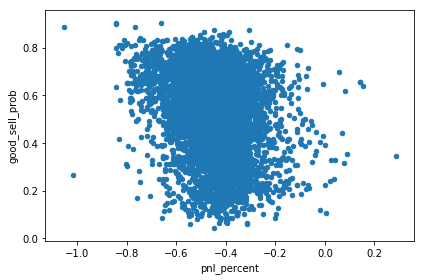

In [24]:
url = plot_rounds(c.query('good_sell_prob > 0.00').plot.scatter(x='pnl_percent', y='good_sell_prob'))
slack("", url, "Model Correlation")

In [ ]:
# ran both data datasets and combine to create an equally weighted ensemble ranking
c["pnl_rank"] = c.pnl.rank(ascending=False)
c["gs_rank"] = c.good_sell_prob.rank(ascending=False)
c["rank"] = (c.pnl_rank + c.gs_rank)
c["zipcode"] = c.zipcode.apply(str)

# filter the output to remove duds
d = c[(c.pnl_percent > -0.2) & (c.good_sell_prob > 0.4) & (c.zipcode.isin(zipcode_list))]

In [28]:
d = c.sort_values("rank").nsmallest(20, "gs_rank")

file = csv_path + 'ensemble/comb_target_list_' + today.strftime('%Y%m%d') + '.csv'
np.round(d[['address', 'zipcode','list','predicted_price','pnl_percent','good_sell_prob','rank','url']], 4).to_csv(file)

slacker.files.upload(file, channels='#progress')

In [29]:
for_sale = pd.read_csv('CSV_backups/ALL-for_sale.csv', index_col=['property_id','transaction_id'])
for_sale['zipcode'] = for_sale.zipcode.apply(str)

/home/ilya/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (12,13,14,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [30]:
from math import radians, cos, sin, asin, sqrt
def haversine(row, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    lon1 = row.longitude
    lat1 = row.latitude
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6367 * c
    return km / 1.60934 # convert to miles

In [31]:
for r, target in d.iterrows():
    print(target.name[0])
    print(target.address)
    target.longitude = for_sale.loc[target.name].longitude
    target.latitude = for_sale.loc[target.name].latitude
    
    # get all properties listed for sale in the same zipcode as our target
    z = for_sale[(for_sale.zipcode == target.zipcode)]
    print(len(z.longitude))
    
    z['dist'] = z.apply(haversine, lon2 = target.longitude, lat2 = target.latitude, axis=1)
    print(z[['address','dist']].nsmallest(5,'dist'))
    

89807
2096 W Vineyard Plains Dr, Queen Creek, AZ 85142 
269
                                                                         address  \
property_id transaction_id                                                         
89807       22582038        2096 W Vineyard Plains Dr, Queen Creek, AZ 85142       
8998775     22581951        2000 W Vineyard Plains Dr, San Tan Valley, AZ 85142    
89170       22582009        2075 W Vineyard Plains Dr, Queen Creek, AZ 85142       
106825      20707086        33860 N Windmill Run, Queen Creek, AZ 85142            
86348       22581943        1963 W Vineyard Plains Dr, Queen Creek, AZ 85142       

                                dist  
property_id transaction_id            
89807       22582038        0.000000  
8998775     22581951        0.057787  
89170       22582009        0.067315  
106825      20707086        0.117416  
86348       22581943        0.120621  
107243
34409 N Levi Ct, Queen Creek, AZ 85142 
269


/home/ilya/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/ilya/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/ilya/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


                                                                    address  \
property_id transaction_id                                                    
107243      22469783        34409 N Levi Ct, Queen Creek, AZ 85142            
107235      22582369        34402 N Levi Ct, Queen Creek, AZ 85142            
81434       22581820        1778 W Sawtooth Way, Queen Creek, AZ 85142        
81782       20697904        1813 W Half Moon Cir, San Tan Valley, AZ 85142    
81134       22581813        1749 W Gold Mine Way, Queen Creek, AZ 85142       

                                dist  
property_id transaction_id            
107243      22469783        0.000000  
107235      22582369        0.006905  
81434       22581820        0.034525  
81782       20697904        0.055240  
81134       22581813        0.117385  
89170
2075 W Vineyard Plains Dr, Queen Creek, AZ 85142 
269
                                                                         address  \
property_id transaction_id   

In [32]:
d

,,pnl,predicted_price,address,zipcode,good_sell_prob,list,url,lat,long,pnl_percent,pnl_rank,gs_rank,rank
property_id,transaction_id,,,,,,,,,,,,,
89807,22582038,-181412.546875,33587.449219,"2096 W Vineyard Plains Dr, Queen Creek, AZ 85142",85142,0.903871,215000,https://www.zillow.com/homedetails/2096-W-Vineyard-Plains-Dr-Queen-Creek-AZ-85142/67434083_zpid/,33.1870,-111.589,-0.843779,7730.0,1.0,7731.0
107243,22469783,-125584.500000,64415.496094,"34409 N Levi Ct, Queen Creek, AZ 85142",85142,0.902111,190000,https://www.zillow.com/homedetails/34409-N-Levi-Ct-Queen-Creek-AZ-85142/111039502_zpid/,33.1918,-111.585,-0.660971,6855.0,2.0,6857.0
89170,22582009,-179980.218750,34019.785156,"2075 W Vineyard Plains Dr, Queen Creek, AZ 85142",85142,0.900716,214000,https://www.zillow.com/homedetails/2075-W-Vineyard-Plains-Dr-Queen-Creek-AZ-85142/67433786_zpid/,33.1865,-111.588,-0.841029,7725.0,3.0,7728.0
8985348,22581788,-185726.234375,56273.769531,"1731 W Cool Water Way, San Tan Valley, AZ 85142",85142,0.888079,242000,https://www.zillow.com/homedetails/1731-W-Cool-Water-Way-San-Tan-Valley-AZ-85142/2093521740_zpid/,33.1976,-111.585,-0.767464,7739.0,4.5,7743.5
80921,22581860,-253124.078125,-13124.072266,"1723 W Dugan Dr, Queen Creek, AZ 85142",85142,0.888079,240000,https://www.zillow.com/homedetails/1723-W-Dugan-Dr-Queen-Creek-AZ-85142/82260262_zpid/,33.2013,-111.585,-1.054684,7761.0,4.5,7765.5
8996258,22562578,-55651.031250,126348.968750,"509 S Mountain Rd, Mesa, AZ 85208",85208,0.874870,182000,https://www.zillow.com/homedetails/509-S-Mountain-Rd-Mesa-AZ-85208/8089896_zpid/,33.4057,-111.589,-0.305775,632.0,6.0,638.0
3357780,22609257,-93720.484375,116179.515625,"16129 W Miami St, Goodyear, AZ 85338",85338,0.873010,209900,https://www.zillow.com/homedetails/16129-W-Miami-St-Goodyear-AZ-85338/71624003_zpid/,NaN,NaN,-0.446501,4015.0,7.0,4022.0
1150392,22485910,-65483.453125,103516.546875,"12637 W Charter Oak Rd, El Mirage, AZ 85335",85335,0.867309,169000,https://www.zillow.com/homedetails/12637-W-Charter-Oak-Rd-El-Mirage-AZ-85335/55284374_zpid/,NaN,NaN,-0.387476,1107.0,8.0,1115.0
81434,22581820,-106445.429688,111054.570312,"1778 W Sawtooth Way, Queen Creek, AZ 85142",85142,0.865181,217500,https://www.zillow.com/homedetails/1778-W-Sawtooth-Way-Queen-Creek-AZ-85142/88903800_zpid/,33.1923,-111.585,-0.489404,5512.0,9.0,5521.0


In [35]:
d.head()

,,pnl,predicted_price,address,zipcode,good_sell_prob,list,url,lat,long,pnl_percent,pnl_rank,gs_rank,rank
property_id,transaction_id,,,,,,,,,,,,,
89807,22582038,-181412.546875,33587.449219,"2096 W Vineyard Plains Dr, Queen Creek, AZ 85142",85142,0.903871,215000,https://www.zillow.com/homedetails/2096-W-Vineyard-Plains-Dr-Queen-Creek-AZ-85142/67434083_zpid/,33.1870,-111.589,-0.843779,7730.0,1.0,7731.0
107243,22469783,-125584.500000,64415.496094,"34409 N Levi Ct, Queen Creek, AZ 85142",85142,0.902111,190000,https://www.zillow.com/homedetails/34409-N-Levi-Ct-Queen-Creek-AZ-85142/111039502_zpid/,33.1918,-111.585,-0.660971,6855.0,2.0,6857.0
89170,22582009,-179980.218750,34019.785156,"2075 W Vineyard Plains Dr, Queen Creek, AZ 85142",85142,0.900716,214000,https://www.zillow.com/homedetails/2075-W-Vineyard-Plains-Dr-Queen-Creek-AZ-85142/67433786_zpid/,33.1865,-111.588,-0.841029,7725.0,3.0,7728.0
8985348,22581788,-185726.234375,56273.769531,"1731 W Cool Water Way, San Tan Valley, AZ 85142",85142,0.888079,242000,https://www.zillow.com/homedetails/1731-W-Cool-Water-Way-San-Tan-Valley-AZ-85142/2093521740_zpid/,33.1976,-111.585,-0.767464,7739.0,4.5,7743.5
80921,22581860,-253124.078125,-13124.072266,"1723 W Dugan Dr, Queen Creek, AZ 85142",85142,0.888079,240000,https://www.zillow.com/homedetails/1723-W-Dugan-Dr-Queen-Creek-AZ-85142/82260262_zpid/,33.2013,-111.585,-1.054684,7761.0,4.5,7765.5
